# Naïve Bayes algorithm for classification

In [185]:
import pickle
import json
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
from sklearn.naive_bayes import GaussianNB, ComplementNB, MultinomialNB, BernoulliNB, CategoricalNB
import matplotlib.pyplot as plt

## Load and preprocess the data

In [186]:
# Read the files
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
validation = pd.read_csv("data/validation.csv")

# Define data cleaner function
def data_cleaner(df):
    data = df.copy()
    
    #remove the id, partlybad columns
    data.drop(["id","partlybad", "date"],1,inplace=True)
    
    #set new index using the date column
    #data.set_index(["date"],inplace=True)
    
    #add binary 'class2' col for event/non-event
    data["class2"] = np.where(data["class4"] == "nonevent", "nonevent","event")
    
    #arrange to put class2 col at the front
    cols = ['class2'] + [col for col in data if col != 'class2']
    
    # Return cleaned and re-arranged dataframe
    return data[cols]

# Run datasets through data_cleaner
train = data_cleaner(train)
test = data_cleaner(test)
validation = data_cleaner(validation)


# Describe
#train.describe()
#test.describe()
#validation.describe()
train

,class2,class4,CO2168.mean,CO2168.std,CO2336.mean,CO2336.std,CO242.mean,CO242.std,CO2504.mean,CO2504.std,...,T672.mean,T672.std,T84.mean,T84.std,UV_A.mean,UV_A.std,UV_B.mean,UV_B.std,CS.mean,CS.std
0,event,Ib,366.630308,3.181254,366.826923,2.734987,370.087744,7.513276,366.449124,2.232670,...,17.622036,2.494032,18.228794,3.178835,22.541204,15.996583,1.124494,0.985257,0.004298,0.001063
1,nonevent,nonevent,391.776292,0.621017,391.699412,0.600427,392.646437,5.147952,391.657727,0.612533,...,-8.814530,0.713217,-7.958920,0.825767,5.855286,3.150759,0.175438,0.113149,0.004925,0.000247
2,nonevent,nonevent,385.172143,1.980306,385.431327,2.253748,385.356633,2.234511,385.368776,1.945493,...,0.484855,0.693120,1.147339,0.760917,4.015310,2.722709,0.154589,0.121509,0.001376,0.000157
3,event,Ib,362.326121,5.906424,362.844880,5.706994,363.604217,7.427512,362.963072,5.513663,...,13.100121,2.223964,13.926774,2.735421,18.000934,13.873148,0.739731,0.666334,0.001462,0.000313
4,nonevent,nonevent,386.233946,3.371362,386.302108,3.300200,387.290378,3.670426,386.357581,3.261596,...,11.496794,0.862327,12.181209,0.799655,5.990780,4.345321,0.312157,0.269510,0.003599,0.000513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,nonevent,nonevent,379.155849,0.278232,379.089074,0.277640,379.327358,0.357890,379.045185,0.242220,...,-4.700031,0.654597,-4.069439,0.605836,0.781134,0.293010,0.015294,0.005811,0.000961,0.000194
254,nonevent,nonevent,373.096633,7.627161,373.184000,7.433646,374.378061,8.002715,373.066103,7.323644,...,12.752325,0.824471,13.188177,0.998421,9.062534,6.394310,0.365023,0.316337,0.003788,0.000803
255,nonevent,nonevent,388.273971,0.710102,388.238676,0.701599,388.578551,0.755712,388.161304,0.701161,...,-5.975207,0.112305,-5.262749,0.215228,2.083735,1.080766,0.037235,0.020486,0.003040,0.000109
256,event,II,381.683141,5.724127,381.709316,5.354609,385.466526,10.259716,381.632670,5.014191,...,19.604545,3.702358,20.096451,3.919209,22.337789,15.794595,1.197271,1.042756,0.003555,0.001285


In [187]:
# Print number of classes in each set
def print_nbr_classes(name, df):
    set_size=len(df)
    print("Set:", name)
    print("Ia:", len(df[df["class4"]=="Ia"]), "pcs", 100*round(len(df[df["class4"]=="Ia"])/set_size, 2), "%")
    print("Ib:", len(df[df["class4"]=="Ib"]), "pcs", 100*round(len(df[df["class4"]=="Ib"])/set_size, 2), "%")
    print("II:", len(df[df["class4"]=="II"]), "pcs", 100*round(len(df[df["class4"]=="II"])/set_size, 2), "%")
    print("nonevent:", len(df[df["class4"]=="nonevent"]), "pcs", 100*round(len(df[df["class4"]=="nonevent"])/set_size, 2), "%")
    print("Total:", set_size, "pcs",)
    print("")

# Print size of the classes
print_nbr_classes("train", train)
print_nbr_classes("test", test)
print_nbr_classes("validation", validation)

Set: train
Ia: 19 pcs 7.000000000000001 %
Ib: 55 pcs 21.0 %
II: 56 pcs 22.0 %
nonevent: 128 pcs 50.0 %
Total: 258 pcs

Set: test
Ia: 2 pcs 2.0 %
Ib: 15 pcs 17.0 %
II: 27 pcs 31.0 %
nonevent: 42 pcs 49.0 %
Total: 86 pcs

Set: validation
Ia: 5 pcs 6.0 %
Ib: 13 pcs 15.0 %
II: 23 pcs 27.0 %
nonevent: 45 pcs 52.0 %
Total: 86 pcs



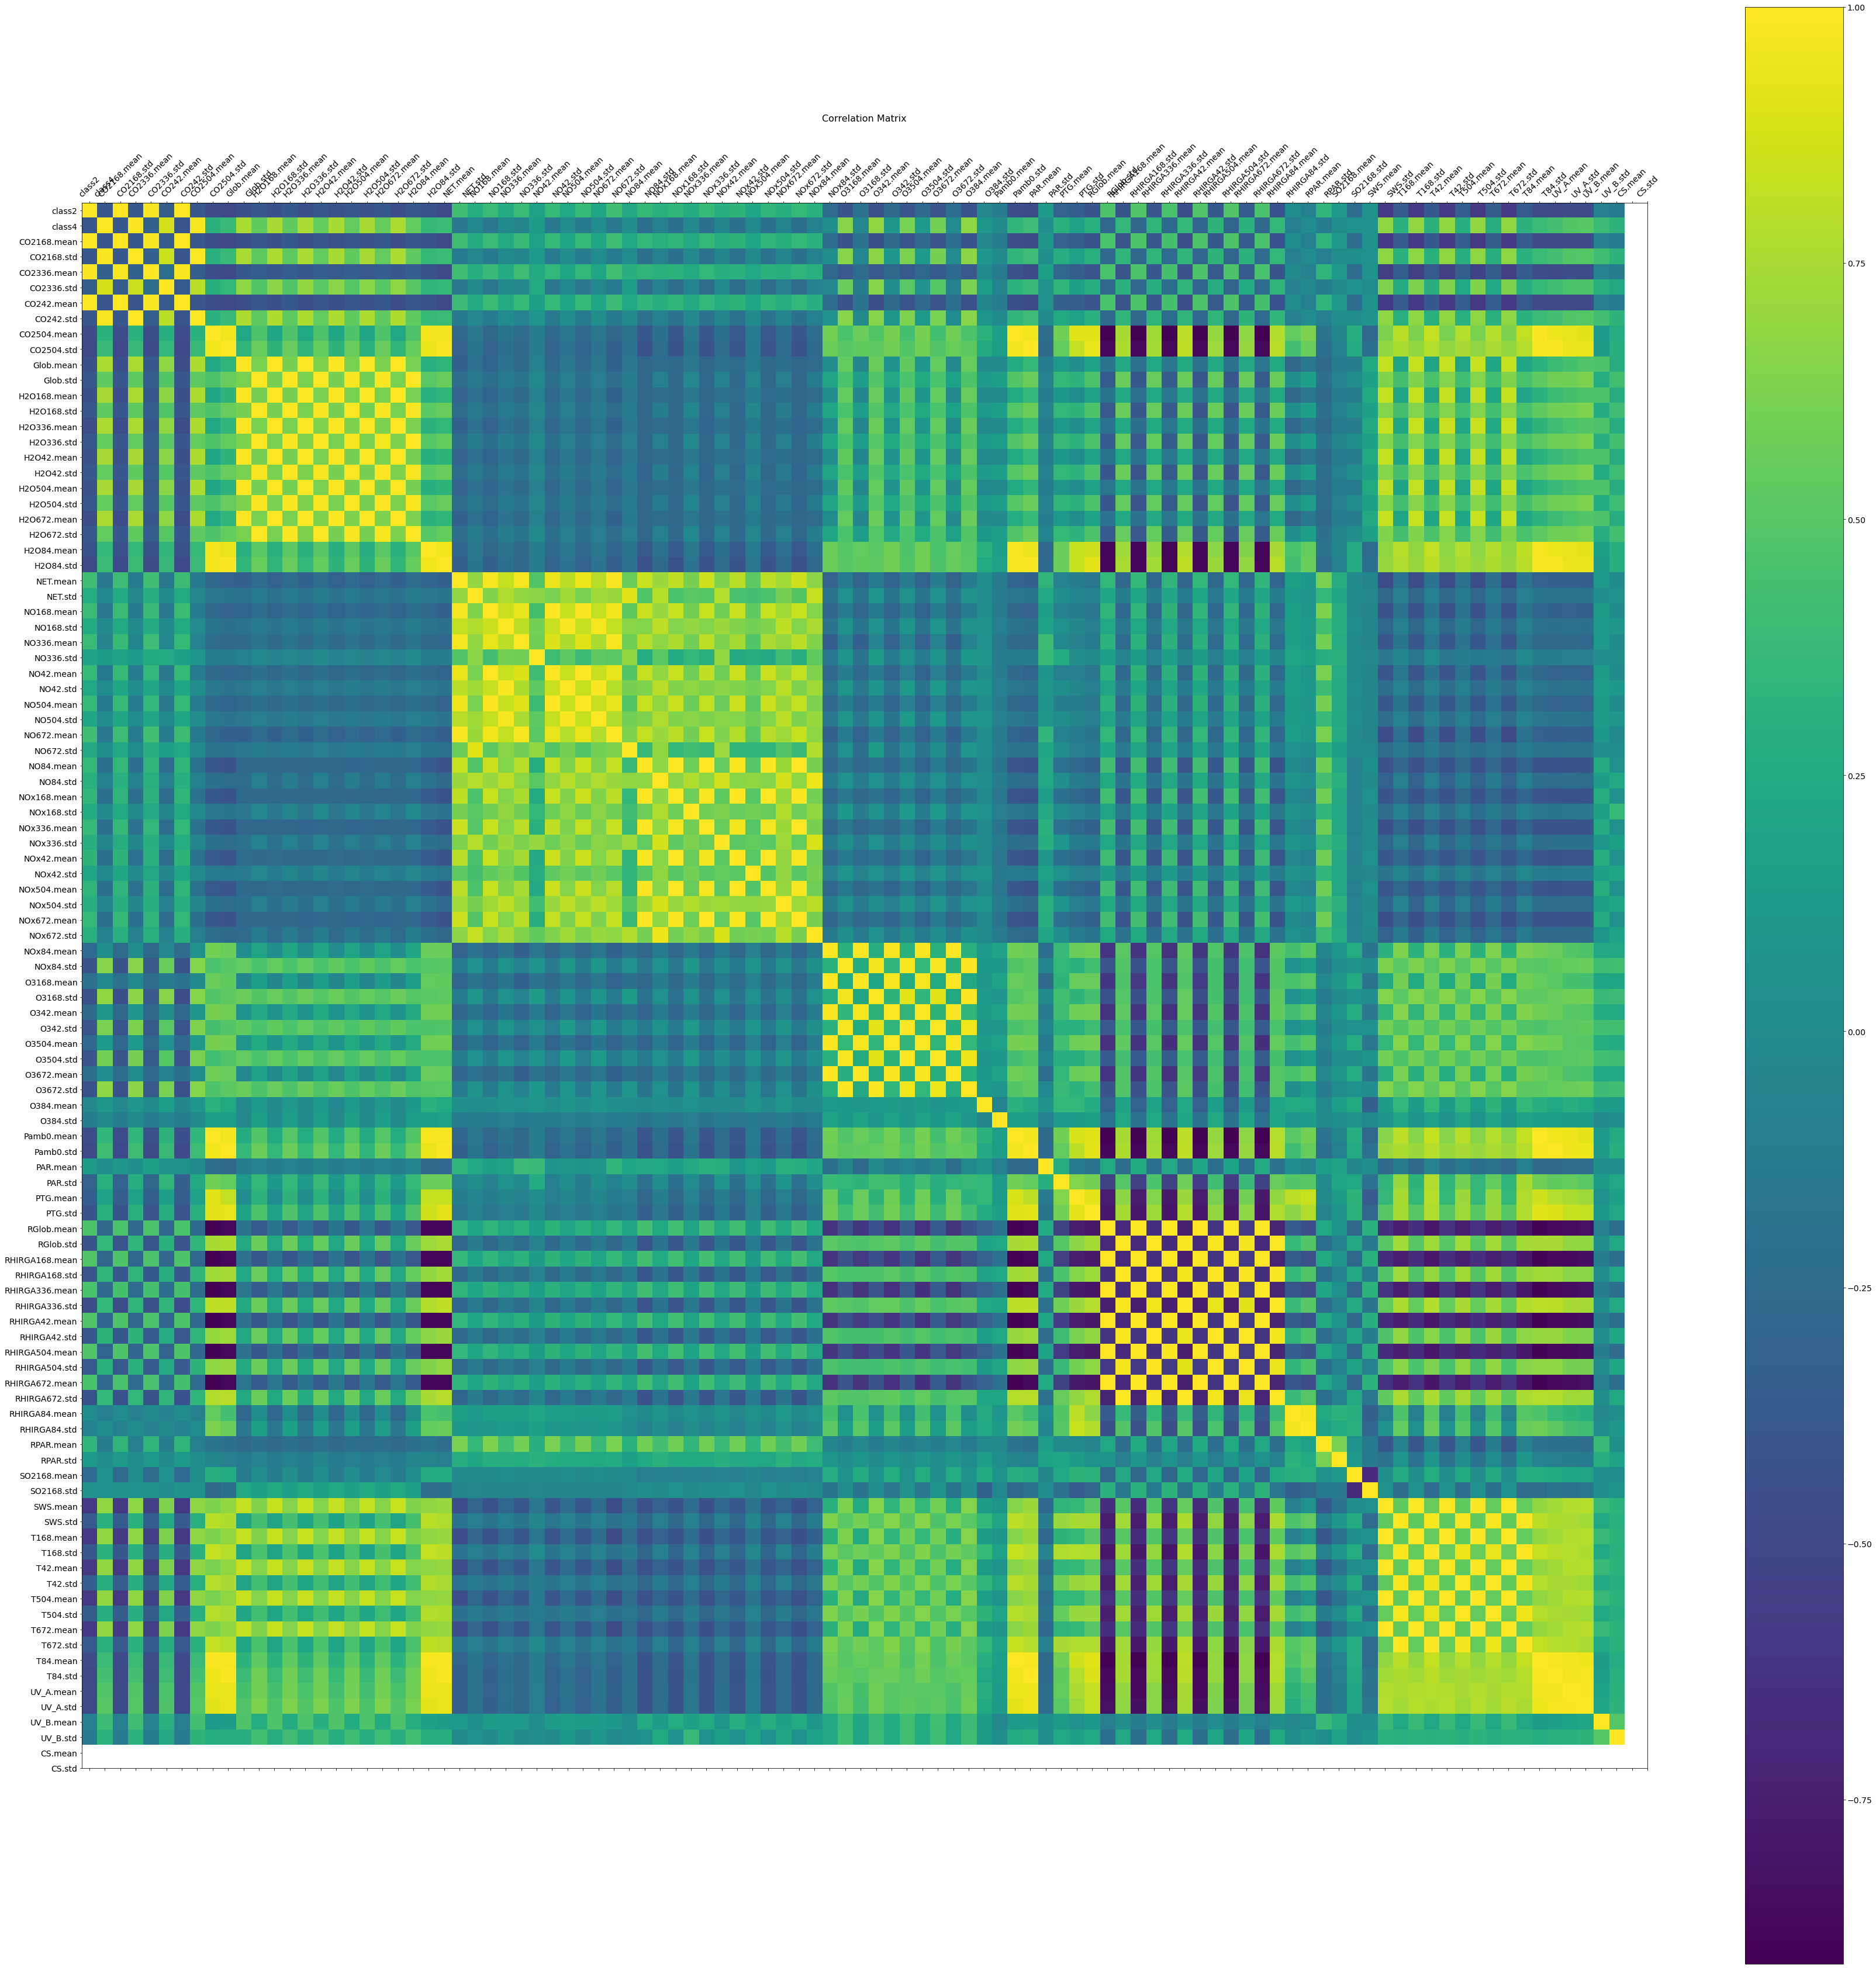

In [188]:
# Select dataframe to use in correlation matrix
df = train

# Plot and show mcorrelation matrix
f = plt.figure(figsize=(60, 60))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

# Save plot as pdf
plt.savefig('train_correlationmatrix.pdf')  

## Gaussian naive bayes

### Binary classification, event vs nonevent

In [189]:
X_train = train.iloc[:,2:]
y_train = train["class2"]

X_val = validation.iloc[:,2:]
y_val = validation["class2"]

X_test = test.iloc[:,2:]
y_test = test["class2"]


model = GaussianNB()
model.fit(X_train, y_train)

print("Gaussian Naive Bayes binary classification")
print("Train set accurancy:", round(accuracy_score(y_train, model.predict(X_train)),2))
print("Test set accurancy:", round(accuracy_score(y_test, model.predict(X_test)),2))
print("Validation set accurancy:", round(accuracy_score(y_val, model.predict(X_val)), 2))

Gaussian Naive Bayes binary classification
Train set accurancy: 0.78
Test set accurancy: 0.84
Validation set accurancy: 0.79


### Multiclass classification

In [190]:
X_train = train.iloc[:,2:]
y_train = train["class4"]

X_val = validation.iloc[:,2:]
y_val = validation["class4"]

X_test = test.iloc[:,2:]
y_test = test["class4"]


model = GaussianNB()
model.fit(X_train, y_train)

print("Gaussian Naive Bayes multi-class classification")
print("Train set accurancy:", round(accuracy_score(y_train, model.predict(X_train)),2))
print("Test set accurancy:", round(accuracy_score(y_test, model.predict(X_test)),2))
print("Validation set accurancy:", round(accuracy_score(y_val, model.predict(X_val)), 2))

Gaussian Naive Bayes multi-class classification
Train set accurancy: 0.55
Test set accurancy: 0.57
Validation set accurancy: 0.58


### Testing gaussian naive bayes accurancy with one feature

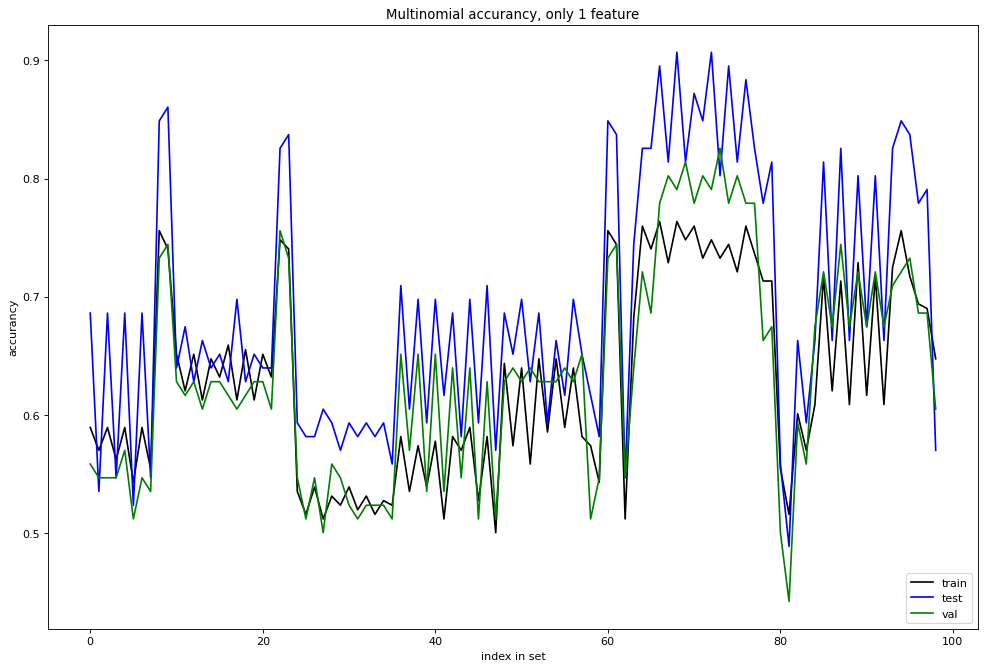

In [191]:
from matplotlib.pyplot import figure

len_cols = len(df.columns)
acc_train = []
acc_test = []
acc_val = []

for i in range(3, len_cols):
    X_train = train.iloc[:,i-1:i]
    y_train = train["class2"]
    X_val = validation.iloc[:,i-1:i]
    y_val = validation["class2"]
    X_test = test.iloc[:,i-1:i]
    y_test = test["class2"]
    model = GaussianNB()
    model.fit(X_train, y_train)
    # Save accurancy to list
    acc_train.append(accuracy_score(y_train, model.predict(X_train)))
    acc_test.append(accuracy_score(y_test, model.predict(X_test)))
    acc_val.append(accuracy_score(y_val, model.predict(X_val)))
 
figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
x = range(0, len(acc_train))
plt.plot(x, acc_train, color="black")
plt.plot(x, acc_test, color="blue")
plt.plot(x, acc_val, color="green")
plt.title('Multinomial accurancy, only 1 feature')
plt.xlabel('index in set')
plt.ylabel('accurancy')
plt.legend(["train", "test", "val"], loc ="lower right") 
plt.show()

## Bernoulli Naive Bayes

### Bernoulli Naive Bayes binomial classification

In [192]:
X_train = train.iloc[:,2:]
y_train = train["class2"]

X_val = validation.iloc[:,2:]
y_val = validation["class2"]

X_test = test.iloc[:,2:]
y_test = test["class2"]


model = BernoulliNB()
model.fit(X_train, y_train)

print("Bernoulli Naive Bayes binary classification")
print("Train set accurancy:", round(accuracy_score(y_train, model.predict(X_train)),2))
print("Test set accurancy:", round(accuracy_score(y_test, model.predict(X_test)),2))
print("Validation set accurancy:", round(accuracy_score(y_val, model.predict(X_val)), 2))

Bernoulli Naive Bayes binary classification
Train set accurancy: 0.62
Test set accurancy: 0.69
Validation set accurancy: 0.69


### Bernoulli Naive Bayes multi-class classification

In [193]:
X_train = train.iloc[:,2:]
y_train = train["class4"]

X_val = validation.iloc[:,2:]
y_val = validation["class4"]

X_test = test.iloc[:,2:]
y_test = test["class4"]


model = BernoulliNB()
model.fit(X_train, y_train)

print("Bernoulli Naive Bayes multi-class classification")
print("Train set accurancy:", round(accuracy_score(y_train, model.predict(X_train)),2))
print("Test set accurancy:", round(accuracy_score(y_test, model.predict(X_test)),2))
print("Validation set accurancy:", round(accuracy_score(y_val, model.predict(X_val)), 2))

Bernoulli Naive Bayes multi-class classification
Train set accurancy: 0.47
Test set accurancy: 0.53
Validation set accurancy: 0.45
